# Speech Data Processing and Recognition

##  Introduction

The purpose of this tutorial is to introduce Speech Data Processing and Recognition.
Speech recognition is one of the important part in practical artificial intelligence. Unlike graph, character, and text, sound is transmitted as waves. Trying to recognize speech patterns by processing these waves directly is difficult. Instead, by doing some speech processing, we can make the recognition problem easier. In this tutorial, two topics will be covered:

* speech feature extraction and processing 
* modelling and recognition

As for the feature extraction, the usage of Mel-Frequency Cepstral Coefficients (MFCC) will be introduced in this tutorial. 

There are many methods of modelling: Hidden Markov models (HMMs), Dynamic time warping(DTW), Neural networks(NN) and Gaussian Mixture Model (GMM). This tutorial will mainly focus on GMM and deep Neural networks.

### Environment setup and configuration
Before writing any codes, you need to have some libraries installed. (By the way, the libraries mentioned below is based on MacOS.)

    $ pip install librosa

`librosa` is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

    $ pip install python_speech_features

`python_speech_features` library provides common speech features for ASR including MFCCs and filterbank energies. 

    $ pip install tensorflow

Tensorflow is an open source machine learning framework for numerical computation using data flow graphs.
Note the installs above is based on conda, please make sure you have installed and updated `conda`. After you run all the installs, make sure the following commands work for you:


In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import re
import sys
import wave
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from random import shuffle
import librosa
import librosa.display
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import sklearn.mixture
%matplotlib inline 
import matplotlib.pyplot as plt

/Users/songxuchen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset
The data we used is human voice of digit (0~9), totally the dataset contains about 220 samples. Therefore, we defined 10 classes, and 10 lists for each digit. each wav file is about one second.

Download the `data.zip` from my attachment and expand it. 

In this tutorial, we divided the training set and test set according to the ratio of 9:1 randomly.

The data preprocessing and training stage is represented as below:

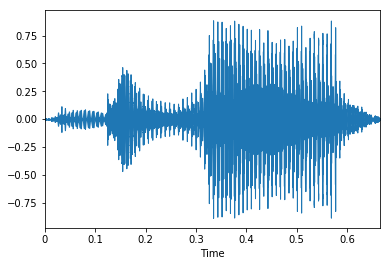

In [13]:
wave, sr = librosa.load('test.wav')
librosa.display.waveplot(wave, sr = sr)

## Speech Feature (MFCC)
MFCC is an important feature, which accurately represents the acoustic characteristic of human.
The speech generated by a human is filtered by the shape of the vocal tract. This shape of vocal tract determines what sound comes out. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum. And MFCCs can describe the envelope with low information loss. Mel Frequency Cepstral Coefficients (MFCC) that can be pictured in Figure below. 

First, voice signal is filtered by using pre-emphasis. Next, the result of the pre-emphasize voice signal is divided into several frames of 160 overlaps. Then, frame blocking result will enter the next process which is windowing using hamming window. Next, the algorithm of Fast Fourier Transform (FFT) is applied to find magnitude spectrum from windowed data. Next phase is mel-filtering, in which this filter uses bank of triangular filter. Next, log module is applied as smoothing function to anticipate loss information when filtering process using mel filter bank is applied. The last phase of MFCC is Discrete Cosine Transform (DCT). This algorithm aims to convert mel spectrum from frequency domain to time domain so, it results features of MFCC. [1]
<img src="picture.png" width="80%">


### MFCC Extraction and Represent
This is the spectrogram for the coefficients for the audio data. Spectrogram is a widely representation of speech. Generally speaking, the format of MFCC extracted by different tools is different. The appropriate tool for extracting MFCC is selected according to the requirements. I will introduce two common libraries that can extract mfcc: 
* librosa 
* python_speech_features

In the `python_speech_features` library, you can define multiple parameters of extracting process, like the analysis window, the step between successive windows and the FFT size. etc. Finally, it will return a numpy array of size, (defined by numcep) containing features. Each row holds a feature vector.

/Users/songxuchen/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


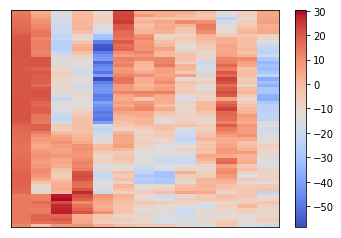

In [12]:
(fs, sig)=wav.read('test.wav')
mfcc_pyspeech = mfcc(sig,fs)
librosa.display.specshow(mfcc_pyspeech)
plt.colorbar()

In the `librosa` library, you can only define the sample rate, dimension of the feature and the log-power Mel spectrogram. Finally, the mfcc sequence output is the shape of mfcc's dimension and time.

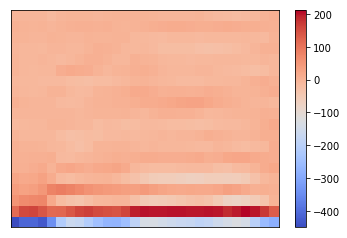

In [4]:
wave, sr = librosa.load('test.wav')
mfcc_librosa = librosa.feature.mfcc(wave, sr)
librosa.display.specshow(mfcc_librosa)
plt.colorbar()

Therefore, we need to choose the appropriate tool to extract MFCC according to the requirements.

## 3. Gaussian Mixture Model (GMM) for Speech Recognition

MFCC-GMM [2] is the most appropriate approach based on parameters like identification accuracy, false acceptance, false rejection rate. This system is based on the classification of MFCC coefficients obtained from the speech signals.
The system consists of three processes:
* Features extraction 
* Training 
* Matching

Extracting features is mentioned as above. Expectation Maximization(EM) algorithm is utilized to train the MFCC features of human voice in system and used to store. In the mating process, the system authenticates the register person by matching the current voice sample to the voice. Then it calculated the log probability of feature vector and compares it to the stored vector. The closest match to the stored vector will be determined as the class in which the stored vector is classified.


In [14]:
leng = 10
mfccs_train=[None]*leng

#extract the train features
for i in range(0, 10):
    mfccs_train[i] = np.empty((0, 13), int)
path = 'train/'
dirs = os.listdir(path)
for file in dirs:
    if not file.endswith(".wav"): continue
    (fs, sig) = wav.read(path + file)
    # label is the 7th character of the filename
    label = int(file[6])
    mfccs_train[label] = np.concatenate((mfccs_train[label], mfcc(sig,fs)), axis=0)

/Users/songxuchen/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Now, we will use MFCCs to build the GMM model. Each GMM consists of K Gaussian distributions. Each Gaussian is called a Component. These components are linearly added together to form the GMM probability density function:
$$ p(x) = \sum_{k=1}^{K} p(k)p(x|k) $$
$$      = \sum_{k=1}^{K} \pi_k N(x|\mu_k, \Sigma_k)                    $$
`sklearn.mixture.GaussianMixture `
is a representation of a Gaussian mixture model probability distribution. `diag` means each component has its own diagonal covariance matrix. `fit` means estimate model parameters with the EM algorithm. The method fits the model and sets the parameters with which has the largest likelihood or lower bound. Within each trial, the method iterates between E-step and M-step for max_iter times until the change of likelihood or lower bound is less than  threshold.
This class allows to estimate the parameters of a Gaussian mixture distribution.

In [15]:
#build the gmm_model by mfccs_train vector
gmm_model = [None] * 10
for num in range(0, 10):
    gmm_model[num] = sklearn.mixture.GaussianMixture(16, 'diag').fit(mfccs_train[num])

After that, we could test the recognition accuracy of the speech dataset. 

the `maxlikelihood` shows the probability of this class, and `ind` represents the class it predicts. `label` is the true label. `score` is to compute the per-sample average log-likelihood of the given data tmp_mfcc.

In [16]:
#extract the test features and test the accuracy
path = 'test/'
dirs = os.listdir(path)
total = 0
counter = 0
mfccs_test=[None]*leng
for file in dirs:
    if not file.endswith(".wav"): continue
    label = int(file[6])
    (fs, sig)=wav.read(path + file)
    maxlikelihood = -1000
    ind = 0
    tmp_mfcc = mfcc(sig,fs)
    for i in range(0, 10):
        # score the test feature by gmm.score
        if (gmm_model[i].score(tmp_mfcc)) > maxlikelihood:
            maxlikelihood = (gmm_model[i].score(tmp_mfcc))
            ind = i
    if ind == label:
        counter += 1
    total += 1
print('The accuracy of the speech recognation using GMM is %s' %str(counter / total * 100), '%')

The accuracy of the speech recognation using GMM is 95.23809523809523 %


/Users/songxuchen/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Deep Neural Networks for Speech Recognition

GMM is just an approximation to make the model trackable and solvable. The large amount of data results in a large dimension of features. There will be a large amount of calculations for the GMM method, and the degree of fitting of the features will become worse.

With enough supervised dataset, the progress of DNN for optimization, one is able to utilize the power of DNN to train a discriminative model rather than GMM generative model. 

### Batch MFCCs
First of all, unlike GMM, we should generate batch MFCCs during the deep neural networks. Unlike the MFCCs of GMM, in the deep neural networks. The input should be the batch mfccs, and the batch features ought to be generated randomly. In addition, since the length of the wav is different, we should cut or pad the features to same size.

In this tutorial, we choose to pad the MFCCs features. And the total size depends on the maximum length of the wav. Therefore, the padding length is maximum length minus actual size.

In this tutorial, the label is the seven characters of the filename. Therefore, we obtain the label by int(file[6]). The dimension of MFCCs is 20, as input for the model. After that, we transform the labels and MFCCs features into vectors and store them for the following utilization.


In [7]:
def mfcc_batch(batch_size, frame_length, classes, path):
    batch_features = []
    labels = []
    files = os.listdir(path)
    while True:
        shuffle(files)
        for file in files:
            #extract mfcc
            if not file.endswith(".wav"): continue
            wave, sr = librosa.load(path + file)
            mfcc = librosa.feature.mfcc(wave, sr)
            
            #label the file
            label = int(file[6])
            label_vec = np.eye(classes)[label]
            labels.append(label_vec)
            
            #since our input of feature needs be the same size,
            #we need pad the feature. And the size is depend on the data length
            padding_size = frame_length - len(mfcc[0])
            mfcc_temp = np.pad(mfcc,((0,0),(0,padding_size)), mode='constant')
            mfcc_trans = np.array(mfcc_temp).transpose()
            batch_features.append(mfcc_trans)
            
            #return the features and labels
            if len(batch_features) >= batch_size:
                features = np.array(batch_features)
                label_vecs = np.array(labels)
                return features, label_vecs

### Long Short-Term Memory
We’ll use a Long Short-Term Memory (LSTM) [3], which is a neural network that has a memory that influences future predictions. Specifically, Long Short-Term Memory (LSTM) layers are a type of recurrent neural network (RNN) architecture which are useful for modelling dataset that has long-term sequential dependencies. In speech recognition problems, the dataset is always the continuous signals, which means the data has time dependencies.
They are important for time series data because they essentially remember past information at the current time point, which influences their output. This context is useful for speech recognition because of its temporal nature.

### LSTM Model based on Tensorflow
In this tutorial, we use `BasicLSTMCell` which is defined by tensorflow [4]. Since the dataset is not so huge, we build one-layer LSTM for speech recognition. First of all, we define the input and output vector to store the features and results. Secondly, we build the model by defining the lstm module, predict function and the `softmax_cross_entropy`. Finally, we utilized the TensorFlow provided `tf.train.AdamOptimizer` to control the learning rate. The AdamOptimizer improves on traditional gradient descent by using momentum which is moving averages of the parameters, facilitating efficient dynamic adjustment of hyper parameters. We can track the loss and error rate by creating summary scalars of the label error rate.

In [8]:
#build the model
feature_input = 20
frames = 60
classes = 10
hidden = 128
net_input = tf.placeholder(tf.float32, shape = (None, frames, feature_input))
net_output = tf.placeholder(tf.float32, shape = (None, classes))

weights = tf.Variable(tf.random_normal([hidden, classes]))
biases = tf.Variable(tf.random_normal([classes]))

x = tf.unstack(net_input, frames, axis = 1)
lstm_cell = rnn.BasicLSTMCell(hidden, forget_bias=1.0)
outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
pred = tf.matmul(outputs[-1], weights)
pred=  tf.add(pred, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = net_output))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
predict_label = tf.argmax(pred, 1)
true_label = tf.argmax(net_output, 1)
correct = tf.equal(tf.argmax(pred, 1), tf.argmax(net_output, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train and Test model
This part is train and test the model, the `training iterations` is 10 thousand, and the `test iterations` is 1 thousand. The `batch_size` is 50.

In [9]:
# train and test the model
training_iters = 10000
test_iters = 1000
batch_size = 50
acc_measure = 10
res = []
with tf.Session() as sess:
    sess.run(init)
    step = 1
    print("Training...")
    path = "train/"
    while step * batch_size <= training_iters:
        batch = mfcc_batch(batch_size, frames, classes, path)
        batch_features, batch_labels = batch
        batch_features = batch_features.reshape((batch_size, frames, feature_input))
        sess.run(optimizer, feed_dict = {net_input: batch_features, net_output: batch_labels})
        if step % acc_measure == 0:
            acc = sess.run(accuracy, feed_dict = {net_input:batch_features, net_output: batch_labels})
            res.append(acc)
            loss = sess.run(cost, feed_dict = {net_input:batch_features, net_output : batch_labels})
            print("training iters is " + str(step * batch_size), "training loss is ", loss, "training accuracy is ", acc)
        step += 1
    print("Testing...")
    path = "test/"
    step = 1
    while step * batch_size <= test_iters:
        batch = mfcc_batch(batch_size, frames, classes, path)
        batch_features, batch_labels = batch
        batch_features = batch_features.reshape((batch_size, frames, feature_input))
        if step % acc_measure == 0:
            acc = sess.run(accuracy, feed_dict={net_input: batch_features, net_output: batch_labels})
            loss = sess.run(cost, feed_dict={net_input: batch_features, net_output : batch_labels})
            print("testing iters is " + str(step * batch_size),"testing loss is ", loss,"testing accuracy is ", acc)
        step += 1
    print("Finish...")

Training...
training iters is 500 training loss is  2.0198138 training accuracy is  0.34
training iters is 1000 training loss is  1.0311276 training accuracy is  0.6
training iters is 1500 training loss is  0.69136834 training accuracy is  0.64
training iters is 2000 training loss is  0.19728558 training accuracy is  0.94
training iters is 2500 training loss is  0.11634717 training accuracy is  0.92
training iters is 3000 training loss is  0.061082076 training accuracy is  0.98
training iters is 3500 training loss is  0.027292343 training accuracy is  1.0
training iters is 4000 training loss is  0.025420882 training accuracy is  1.0
training iters is 4500 training loss is  0.009444024 training accuracy is  1.0
training iters is 5000 training loss is  0.003186337 training accuracy is  1.0
training iters is 5500 training loss is  0.0022862079 training accuracy is  1.0
training iters is 6000 training loss is  0.0013458017 training accuracy is  1.0
training iters is 6500 training loss is  

### Training trend
This figure is the training accuracy of the total experiment, which represents the network is converge. And the whole training process is stable.

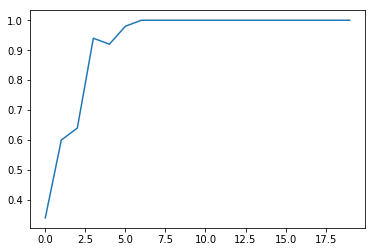

In [10]:
plt.plot(np.arange(len(res)), res)

## Conclusion
Gaussian Mixture Model and Deep Neural Networks are two ways to classify frames in the speech.

From the experiment above, The accuracy of the speech recognation using GMM is 95%. The test accuracy of LSTM is 94%.
we could infer that they both perform well in the small dataset speech recognition task.

As for the running time, we could know the Gaussian Mixture Model computing fast, and the model is easier to learn. GMM training is reliable when used to solve the single character speech recognition task. When dealing with the continuous speech recognition task, the dimension that GMM need to calculate is huge. And the huge features set is hard for storage.

Long Short-Term Memorys are more accurate classifiers than GMM. At the same time Long Short-Term Memorys is slower to train compared to GMM, but they usually require GPU to calculate parallel. Due to the multiple layers, the LSTM often has millions of parameters, which leads to more computational complexity.

In a broad sense, DNN training often needs great initial parameters, and it is hard to choose suitable initial hyper parameters. GMM's alignment is accuracy, and the model does not have random results. Even you train the DNN with clean data, DNN cannot guaranteed to converge.

Congratulation! Now you are equipped with some knowledge about two Speech Recognition methods and their core ideas.

### Reference
[1] Tychtl, Zbyni k dan Psutka, Josef. Speech Production Based on the Mel-Frequency Cepstral Coefficients.

[2] M. N. Stuttle, "A Gaussian mixture model spectral representa- tion for speech recognition," Ph.D dissertation, University of Cambridge, 2003.

[3] H. Soltau, H. Liao, and H. Sak, “Neural speech recog- nizer: Acoustic-to-word lstm model for large vocabulary speech recognition,” arXiv preprint arXiv:1610.09975, 2016.

[4]  https://www.tensorflow.org